In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/devnagri-script-classification/Data/Train",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 78200 files belonging to 46 classes.


2021-10-23 06:25:23.981203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 06:25:24.069052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 06:25:24.069774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 06:25:24.072647: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
class_names = dataset.class_names

In [5]:
class_names

['character_10_yna',
 'character_11_taamatar',
 'character_12_thaa',
 'character_13_daa',
 'character_14_dhaa',
 'character_15_adna',
 'character_16_tabala',
 'character_17_tha',
 'character_18_da',
 'character_19_dha',
 'character_1_ka',
 'character_20_na',
 'character_21_pa',
 'character_22_pha',
 'character_23_ba',
 'character_24_bha',
 'character_25_ma',
 'character_26_yaw',
 'character_27_ra',
 'character_28_la',
 'character_29_waw',
 'character_2_kha',
 'character_30_motosaw',
 'character_31_petchiryakha',
 'character_32_patalosaw',
 'character_33_ha',
 'character_34_chhya',
 'character_35_tra',
 'character_36_gya',
 'character_3_ga',
 'character_4_gha',
 'character_5_kna',
 'character_6_cha',
 'character_7_chha',
 'character_8_ja',
 'character_9_jha',
 'digit_0',
 'digit_1',
 'digit_2',
 'digit_3',
 'digit_4',
 'digit_5',
 'digit_6',
 'digit_7',
 'digit_8',
 'digit_9']

2021-10-23 06:25:26.452944: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


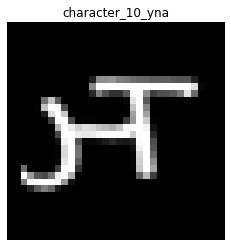

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [7]:
def partition(data, train_split=0.9, valid_split=0.1, shuffle=True, shuffle_size=10000):
    data_size = len(data)
    
    if shuffle:
        data = data.shuffle(shuffle_size, seed=12)
    
    train_size = int(data_size*train_split)
    
    train_ds = data.take(train_size)
    valid_ds = data.skip(train_size)

    return train_ds, valid_ds

In [8]:
train_ds, valid_ds = partition(dataset)

In [9]:
len(train_ds), len(valid_ds)

(2199, 245)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [11]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
Data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = tf.keras.models.Sequential([
    resize_and_rescale,
    Data_augmentation,
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu', input_shape = input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2,  padding='same'),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2,  padding='same'),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2,  padding='same'),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')    
])

model.build(input_shape = input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 32, 32, 3)           0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 32, 32, 3)           0         
_________________________________________________________________
conv2d (Conv2D)              (32, 32, 32, 32)          896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 16, 16, 32)          0         
_________________________________________________________________
batch_normalization (BatchNo (32, 16, 16, 32)          128       
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 16, 16, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 8, 8, 64)           

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1
)

Epoch 1/100


2021-10-23 06:25:38.727263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 289 of 10000
2021-10-23 06:25:48.704386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 582 of 10000
2021-10-23 06:25:58.703078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 878 of 10000
2021-10-23 06:26:08.724966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1174 of 10000
2021-10-23 06:26:18.710753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1464 of 10000
2021-10-23 06:26:28.729150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1753 of 10000
2021-10-23 06:26:38.728747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up 

2190/2199 [============================>.] - ETA: 0s - loss: 0.4721 - accuracy: 0.8637

2021-10-23 06:27:16.999139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1504 of 10000
2021-10-23 06:27:22.810213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-10-23 06:27:22.813966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2021-10-23 06:27:22.814913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


2199/2199 [==============================] - 116s 12ms/step - loss: 0.4708 - accuracy: 0.8641 - val_loss: 0.3109 - val_accuracy: 0.9177
Epoch 2/100
2199/2199 [==============================] - 9s 4ms/step - loss: 0.1738 - accuracy: 0.9475 - val_loss: 0.1341 - val_accuracy: 0.9630
Epoch 3/100
2199/2199 [==============================] - 9s 4ms/step - loss: 0.1280 - accuracy: 0.9624 - val_loss: 0.0880 - val_accuracy: 0.9750
Epoch 4/100
2199/2199 [==============================] - 10s 5ms/step - loss: 0.1025 - accuracy: 0.9694 - val_loss: 0.0920 - val_accuracy: 0.9754
Epoch 5/100
2199/2199 [==============================] - 10s 4ms/step - loss: 0.0835 - accuracy: 0.9755 - val_loss: 0.0735 - val_accuracy: 0.9796
Epoch 6/100
2199/2199 [==============================] - 9s 4ms/step - loss: 0.0731 - accuracy: 0.9782 - val_loss: 0.0547 - val_accuracy: 0.9846
Epoch 7/100
2199/2199 [==============================] - 10s 5ms/step - loss: 0.0624 - accuracy: 0.9811 - val_loss: 0.0581 - val_accuracy

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

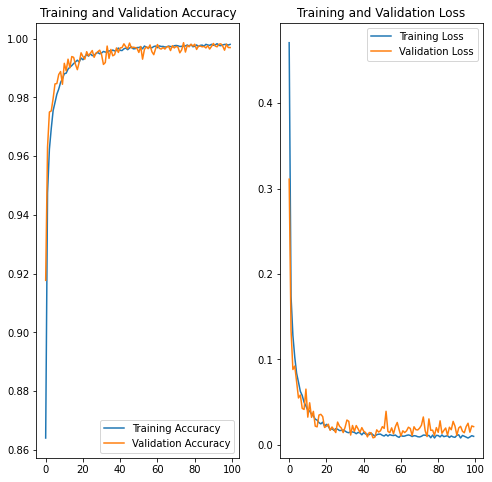

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model.save("model")

2021-10-23 06:48:26.209665: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [20]:
sample = pd.read_csv('../input/devnagri-script-classification/Data/sample_submission.csv')

In [21]:
import os
import cv2

folder_path = '../input/devnagri-script-classification/Data/Test'

images = []

for i in range(sample.shape[0]):
    img = os.path.join(folder_path, str(i+1)+'.png')
    img = cv2.imread(img)
    images.append(img)

In [22]:
images = np.array(images)
images.shape

(13800, 32, 32, 3)

In [23]:
temp = np.argmax(model.predict(images), axis=1)
preds=[]
for i in temp:
    preds.append(class_names[i])

In [24]:
sample['Category'] = preds
sample.to_csv('submission.csv', index=False)